## 3. Find streams at HUC outlets

Use this notebook to find the streams that occur the farthest downstream in a given HUC. We need to use the full National Hydrologic Model Geospatial Fabric for this, since it has the to/from flow attributes populated. We will then crosswalk back to our project stream network to add attributes denoting if a stream is a HUC outlet.

### How?

Each NHM-GF stream has a `To_POI_ID` attribute with the ID of the next downstream segment. If we list all stream IDs occuring in a given HUC polygon, and also list the `To_POI_ID` stream IDs, the stream that has a `POI_ID` value that is not the the full list of HUC streams should be the furthest downstream segment. In other words, if a stream flows to a stream that is not in the HUC, it must be flowing out of the HUC and therefore is the furthest downstream.

### NOTE:

There are some duplicate `POI_ID` values in the source data. These are artifacts that we won't be able to fix. Of the ~56,000 segments, ~150 have duplicate `POI_ID` values, but unique `seg_id_nat` values. So less than 1% of the IDs may present problems if the duplicates reside in the same HUC. We are going to proceed here knowing that there may be a few errors in the outlet population, but on the whole this method is sound.

### Source data

NHM Geospatial Fabric: `/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/GeospatialFabric_National.gdb`

NHD HUC8 polygons: `/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/WBDHU8.shp`

Hydroviz segments (crosswalked): `/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg.shp`

In [59]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import random

### Data Prep

Import data and adjust CRS.

In [ ]:
gf_seg_gdf = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/GeospatialFabric_National.gdb", layer='nsegmentNationalIdentifier', encoding='utf-8')
huc8_gdf = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/WBDHU8.shp", encoding='utf-8')
seg = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg.shp", encoding='utf-8')

# adjust CRS to match seg.shp
gf_seg_gdf = gf_seg_gdf.to_crs(seg.crs)
huc8_gdf = huc8_gdf.to_crs(seg.crs)

Quick check: do all NHM-GF segments have `POI_ID` and `To_POI_ID` populated? If the `To_POI_ID` is missing, this is probably an outlet to the ocean. 

In [30]:
missing_poi = gf_seg_gdf['POI_ID'].isna().sum()
print(f"Number of segments with missing POI_ID: {missing_poi}")
missing_to_poi = gf_seg_gdf['To_POI_ID'].isna().sum()
print(f"Number of segments with missing To_POI_ID: {missing_to_poi}")

Number of segments with missing POI_ID: 0
Number of segments with missing To_POI_ID: 1594


Convert these POI fields to integer, replacing NaN with -9999.

In [31]:
gf_seg_gdf['POI_ID'] = gf_seg_gdf['POI_ID'].fillna(-9999).astype(int)
gf_seg_gdf['To_POI_ID'] = gf_seg_gdf['To_POI_ID'].fillna(-9999).astype(int)

### Spatial join to HUC8 polygons

For each stream segment, find the representative point and determine which HUC8 polygon it falls within. Use the `huc8` attribute as the ID, and add a column to the `gf_seg_gdf` geodataframe.

In [32]:
gf_seg_gdf['huc8'] = gf_seg_gdf.geometry.representative_point().apply(lambda point: huc8_gdf[huc8_gdf.contains(point)]['huc8'].values[0])

### Function test

In [34]:
def find_outlets(gdf, huc8_id, test_print=False):
    if test_print:
        print(f"HUC8: {huc8_id}")

    # subset the gdf
    subset = gdf[gdf['huc8'] == huc8_id]

    # get sets of POI_IDs and To_POI_IDs in the HUC
    huc_pois = set(subset['POI_ID'])
    huc_to_pois = set(subset['To_POI_ID'])
    if test_print:
        print(f"HUC POI_IDs: {huc_pois}")
        print(f"HUC To_POI_IDs: {huc_to_pois}")

    # find stream segments that flow to segments outside the HUC
    # these are considered the HUC outlets
    outside_pois = huc_to_pois - huc_pois
    if test_print:
        print(f"Outside HUC POI_IDs: {outside_pois}")

    outlets = subset[subset['To_POI_ID'].isin(outside_pois)]
    if test_print:
        print(f"Found {len(outlets)} outlet segments.")
        display(outlets)

    return outlets

In [50]:
def plot_huc_outlets(gdf, huc8_ids, segments, label='Segments'):
    huc8_shape = huc8_gdf[huc8_gdf['huc8'].isin(huc8_ids)]

    fig, ax = plt.subplots(figsize=(10, 10))
    huc8_shape.boundary.plot(ax=ax, color='black', linewidth=2)
    gdf[gdf['huc8'].isin(huc8_ids)].plot(ax=ax, color='blue', linewidth=1, label='Streams in HUC')
    segments.plot(ax=ax, color='red', linewidth=3, label=label)
    plt.title(f"HUC8: {', '.join(huc8_ids)} with {label}")
    plt.legend()
    plt.show()

HUC8: 09010004
HUC POI_IDs: {14156416, 14156484, 14156614, 14156742, 14156648, 14156650, 14156652, 14156658, 14156822}
HUC To_POI_IDs: {14156484, 14156742, 14156614, 14156648, 14156650, 14156652, 14156658, 14156822, 14169915}
Outside HUC POI_IDs: {14169915}
Found 1 outlet segments.


,POI_ID,SUM_LENGTHKM,MIN_HYDROSEQ,MAX_STARTFLAG,MAX_SO,SUM_TRAV_TIME,MAX_CUMDRAINAG,TOCOMID2,To_POI_ID,PROD_UNIT,...,FTYPE,TOFTYPE,regionOutlet,ToRegion,ToRegionToSegment,seg_id_nat,seg_id_reg,Shape_Length,geometry,huc8
23847,14156822,17.663,8.620900e+09,0.0,5.0,13.03407,4254.72,14169691,14169915,9a,...,StreamRiver,StreamRiver,0,NaN,NaN,23848,575,17662.50011,"MULTILINESTRING ((-331645.989 2849221.996, -33...",09010004


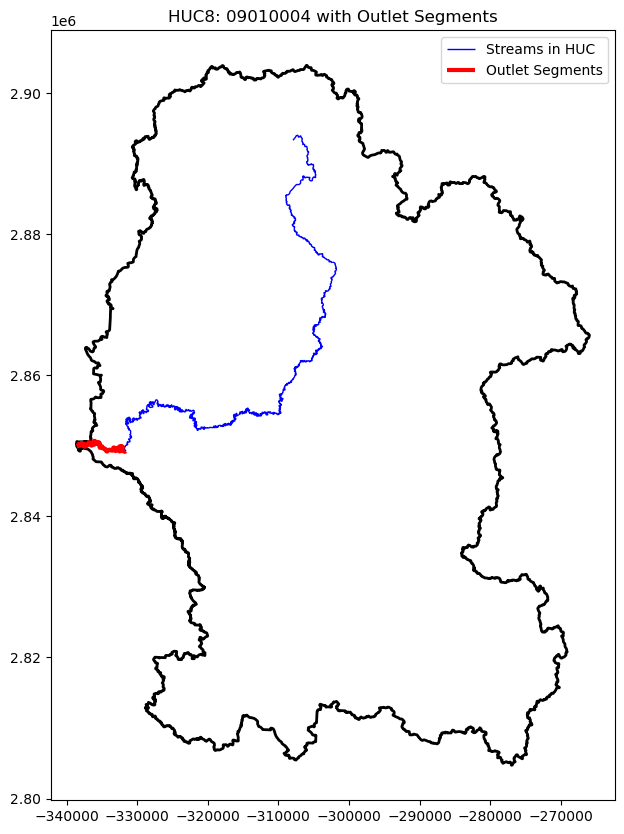

In [51]:
# inland HUC, should have 1 outlet (POI_ID = 14156822)
test_huc = "09010004"
outlet_segs = find_outlets(gf_seg_gdf, test_huc, test_print=True)
plot_huc_outlets(gf_seg_gdf, [test_huc], outlet_segs, label='Outlet Segments')

HUC8: 07100002
HUC POI_IDs: {6588289, 6586473, 6588207, 6586993, 6587189, 6588281, 6588317}
HUC To_POI_IDs: {6588289, 6594440, 6588207, 6586993, 6587189, 6588281, 6588317}
Outside HUC POI_IDs: {6594440}
Found 1 outlet segments.


,POI_ID,SUM_LENGTHKM,MIN_HYDROSEQ,MAX_STARTFLAG,MAX_SO,SUM_TRAV_TIME,MAX_CUMDRAINAG,TOCOMID2,To_POI_ID,PROD_UNIT,...,FTYPE,TOFTYPE,regionOutlet,ToRegion,ToRegionToSegment,seg_id_nat,seg_id_reg,Shape_Length,geometry,huc8
18608,6588289,2.437,1.039100e+09,0.0,6.0,1.651767,5926.6665,6594398,6594440,7b,...,ArtificialPath,ArtificialPath,0,NaN,NaN,18609,1674,2437.802569,"MULTILINESTRING ((145034.919 2188744.004, 1450...",07100002


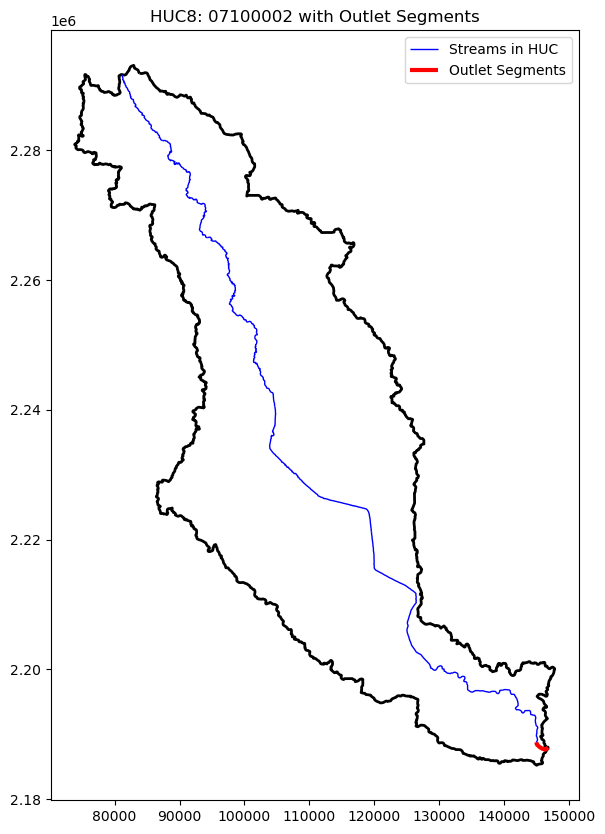

In [52]:
# inland HUC, has one inlet (POI_ID = 6586473) and 1 outlet (POI_ID = 6588289)
# only the outlet should be returned
test_huc = "07100002"
outlet_segs = find_outlets(gf_seg_gdf, test_huc, test_print=True)
plot_huc_outlets(gf_seg_gdf, [test_huc], outlet_segs, label='Outlet Segments')

HUC8: 03140102
HUC POI_IDs: {478985, 476941, 476177, 476885, 478975}
HUC To_POI_IDs: {-9999, 478985, 476885, 478975}
Outside HUC POI_IDs: {-9999}
Found 2 outlet segments.


,POI_ID,SUM_LENGTHKM,MIN_HYDROSEQ,MAX_STARTFLAG,MAX_SO,SUM_TRAV_TIME,MAX_CUMDRAINAG,TOCOMID2,To_POI_ID,PROD_UNIT,...,FTYPE,TOFTYPE,regionOutlet,ToRegion,ToRegionToSegment,seg_id_nat,seg_id_reg,Shape_Length,geometry,huc8
4287,478975,20.451,8.072400e+09,0.0,4.0,18.008274,336.281,478935,-9999,3b,...,ArtificialPath,Coastline,0,NaN,NaN,4288,36,20452.082911,"MULTILINESTRING ((938861.687 885206.691, 93888...",03140102
4288,478985,9.659,8.072400e+09,0.0,3.0,9.021285,215.049,26847053,-9999,3b,...,ArtificialPath,Coastline,0,NaN,NaN,4289,37,9660.279313,"MULTILINESTRING ((905858.421 875454.389, 90587...",03140102


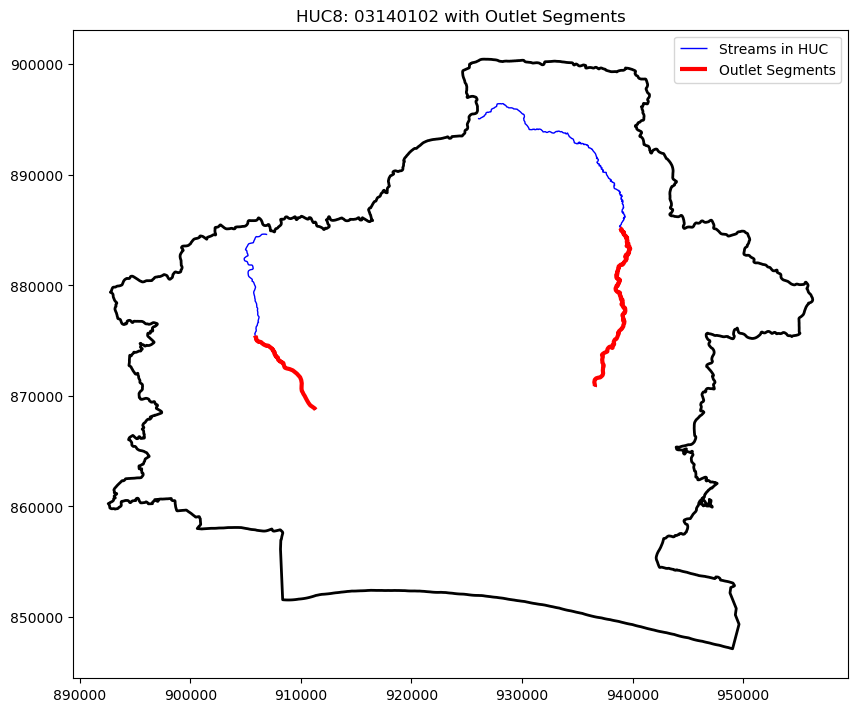

In [53]:
# coastal HUC, has no inlets and 2 outlets (POI_ID = 478985 and POI_ID = 478975)
# only the outlet should be returned
test_huc = "03140102"
outlet_segs = find_outlets(gf_seg_gdf, test_huc, test_print=True)
plot_huc_outlets(gf_seg_gdf, [test_huc], outlet_segs, label='Outlet Segments')

### Find all HUC8 outlets

Use the `find_outlets()` function to find the outlet of each HUC8 in the `gf_seg_gdf` dataframe and populate a new column `huc8_outlet` with a boolean "True" or "False" value.

In [55]:
gf_seg_gdf['huc8_outlet'] = False

outlet_pois_list = []

for huc8 in gf_seg_gdf['huc8'].unique():
    outlet_segs = find_outlets(gf_seg_gdf, huc8)
    outlet_pois_list.append(outlet_segs["POI_ID"].tolist())

outlet_pois = [item for sublist in outlet_pois_list for item in sublist]

gf_seg_gdf.loc[gf_seg_gdf['POI_ID'].isin(outlet_pois), 'huc8_outlet'] = True

In [56]:
# count true false in huc8_outlet column
huc8_outlet_counts = gf_seg_gdf['huc8_outlet'].value_counts()
print(huc8_outlet_counts)

huc8_outlet
False    53295
True      3560
Name: count, dtype: int64


### Join to crosswalked segments

Join the `huc8_outlet` column to the crosswalked segments geodataframe and save as a new file.

In [61]:
gf_seg_gdf_poi_huc8_outlets = gf_seg_gdf[['seg_id_nat', 'huc8_outlet', 'huc8']]
seg_joined = pd.merge(seg, gf_seg_gdf_poi_huc8_outlets, how='left', left_on='seg_id_nat', right_on='seg_id_nat').drop(columns=['region', 'POI_ID'])
seg_joined

,seg_id_nat,GNIS_NAME,geometry,huc8_outlet,huc8
0,1,West Branch Mattawamkeag River,"LINESTRING (2101948.624 2876678.641, 2101941.3...",False,01020003
1,2,Baskahegan Stream,"LINESTRING (2167789.031 2829021.852, 2167729.9...",False,01020003
2,3,Mattawamkeag River,"LINESTRING (2131936.492 2865675.020, 2131955.7...",False,01020003
3,4,Mattawamkeag River,"LINESTRING (2151719.943 2849594.051, 2151812.0...",False,01020003
4,5,Baskahegan Stream,"LINESTRING (2155981.103 2842240.715, 2155894.2...",False,01020003
...,...,...,...,...,...
56459,56456,NaN,"LINESTRING (-1943922.030 1664269.470, -1943834...",True,18090205
56460,56457,NaN,"LINESTRING (-1939576.427 1684173.491, -1939582...",True,18090103
56461,56458,Owens River,"LINESTRING (-1941082.934 1778819.137, -1941078...",True,18090103
56462,56459,NaN,"LINESTRING (-2283644.191 2427521.123, -2283652...",True,18010101


### QC random HUC8s

Pick 20 random HUC8s and plot the streams and outlets.

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


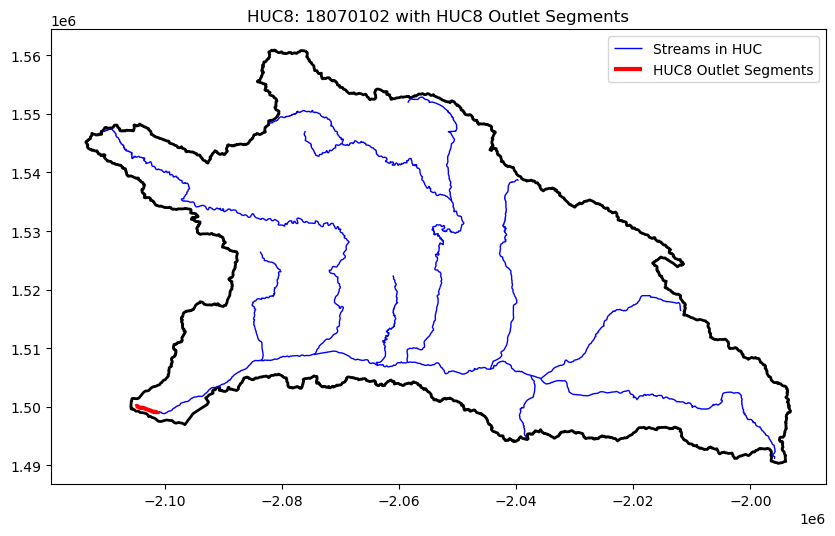

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


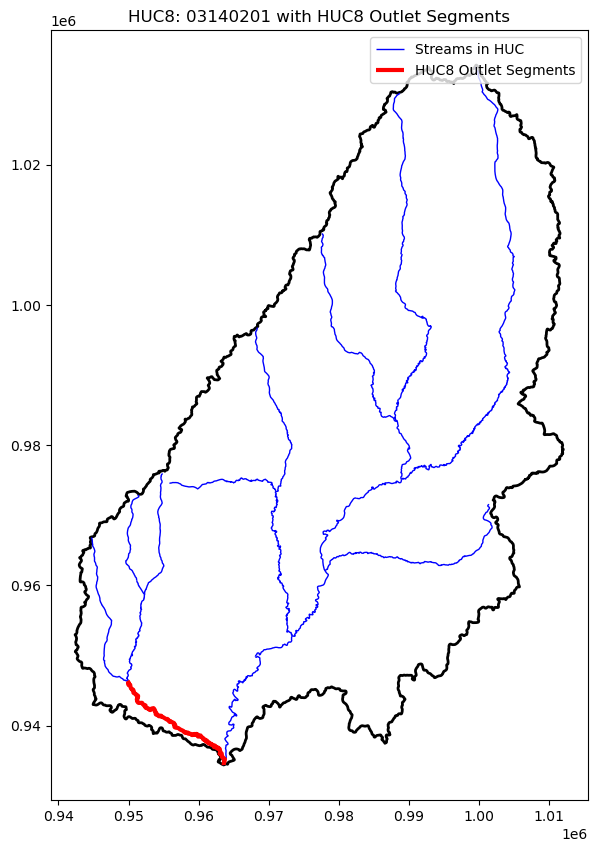

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


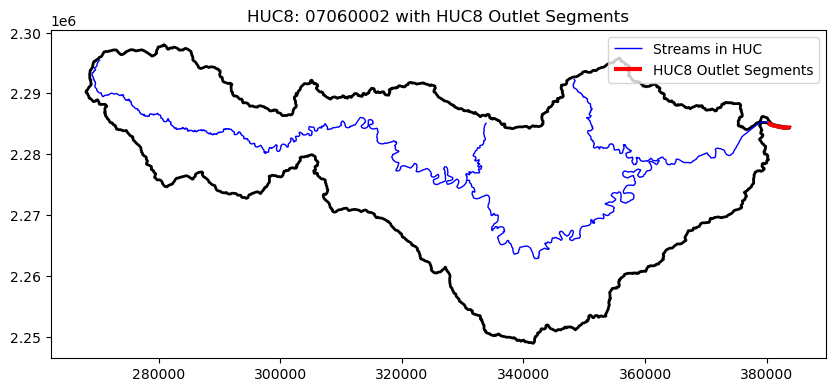

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


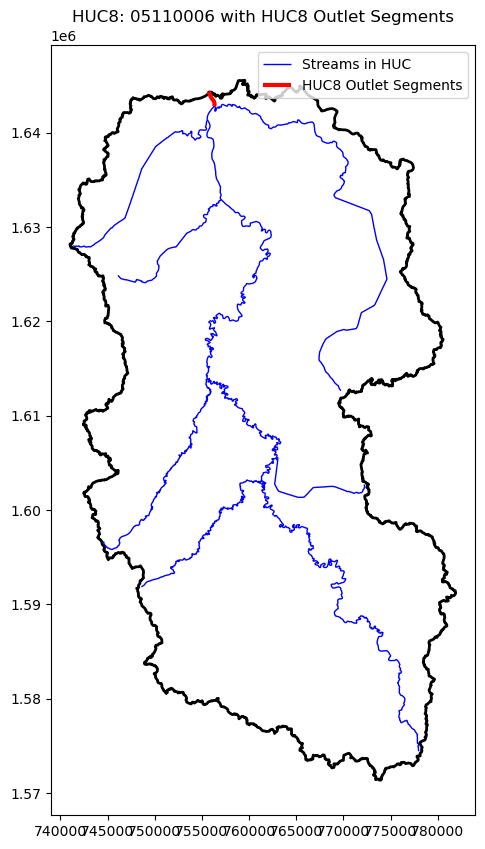

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


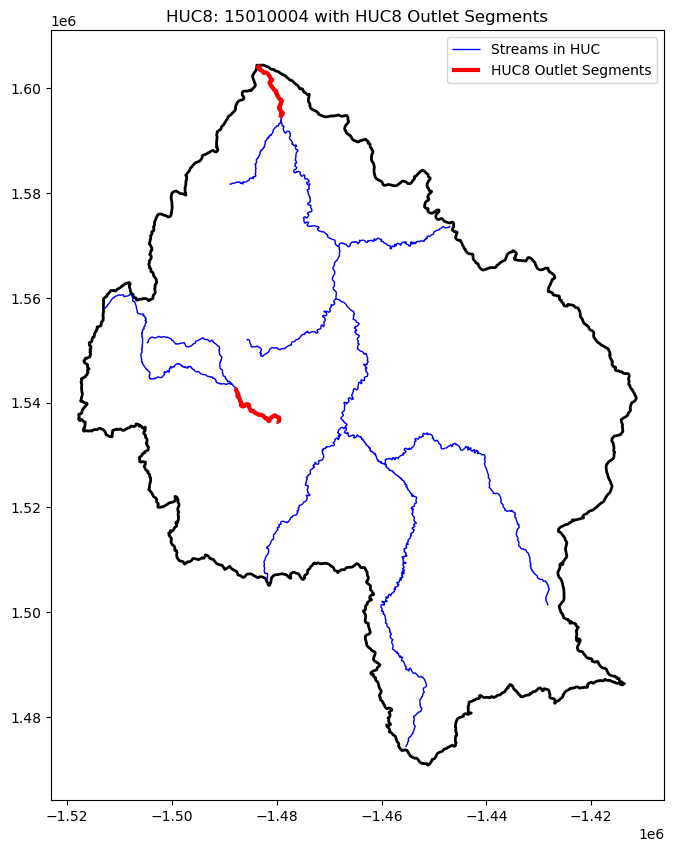

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


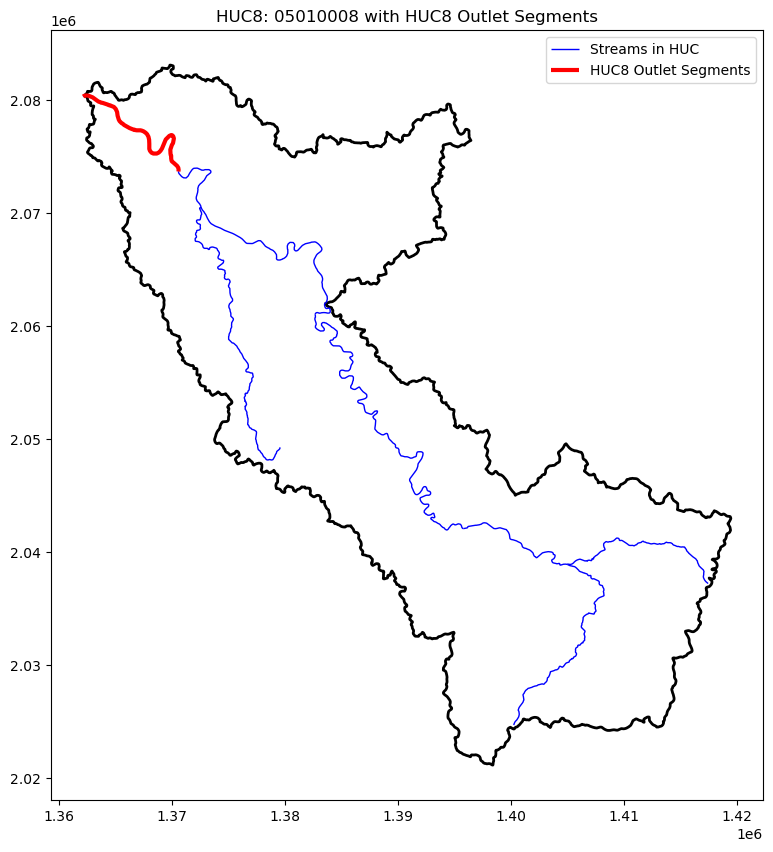

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


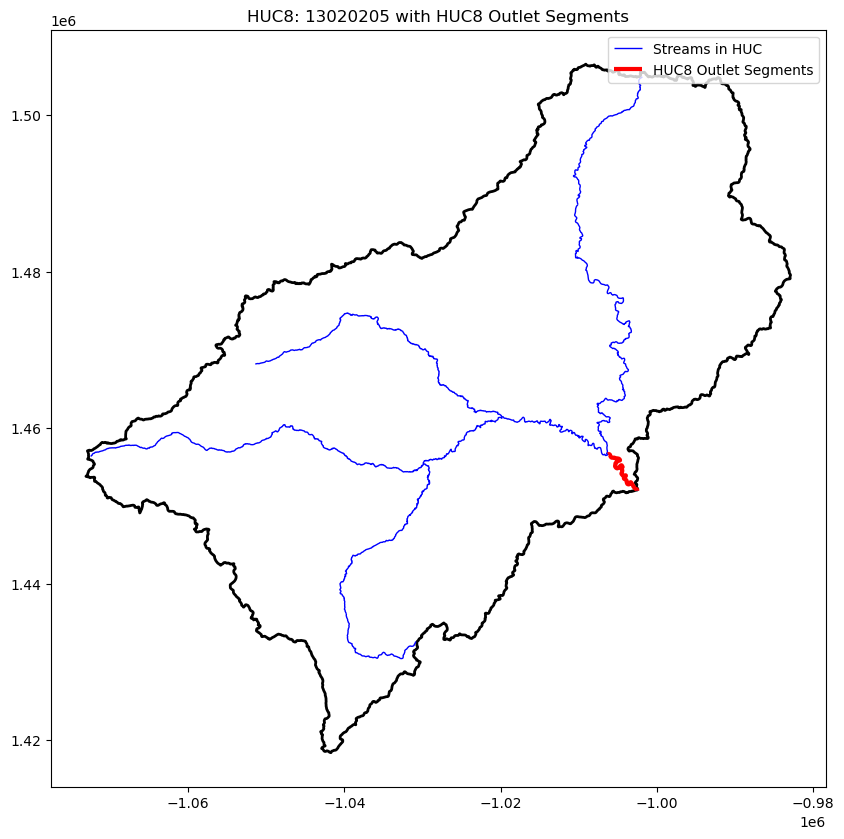

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


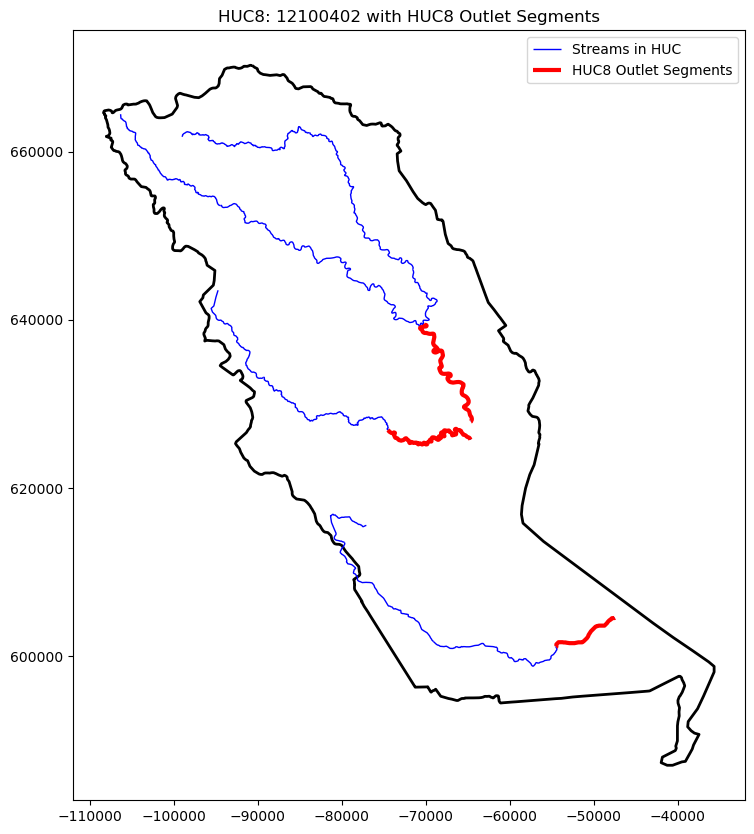

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


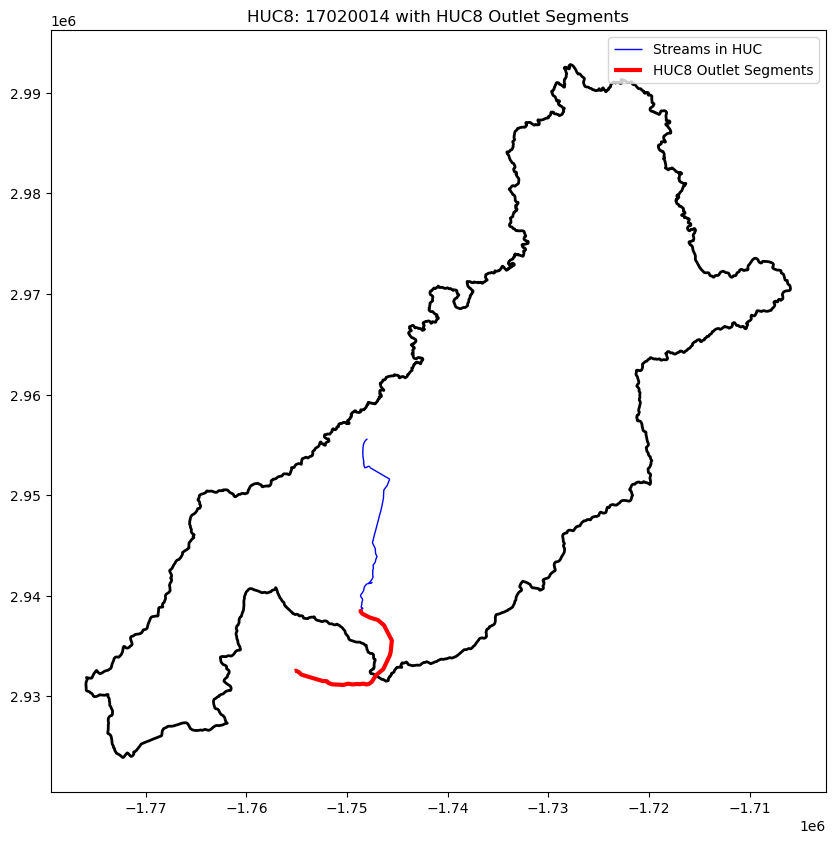

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


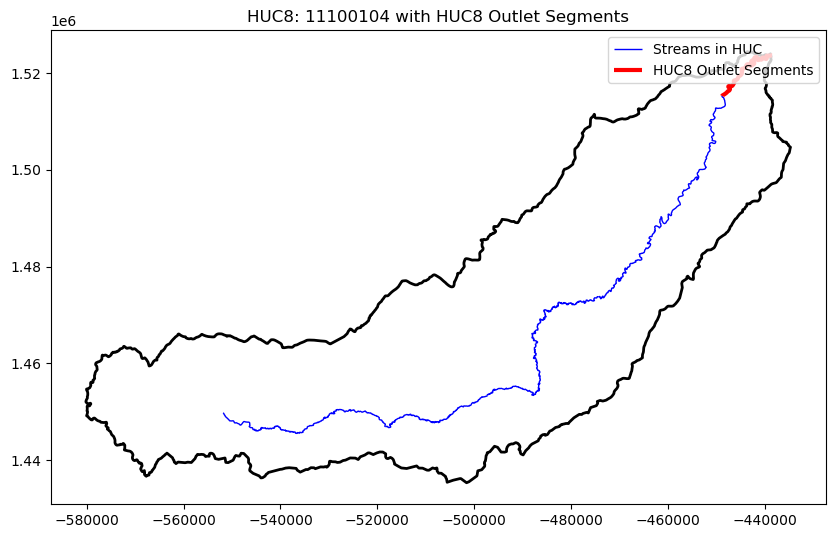

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


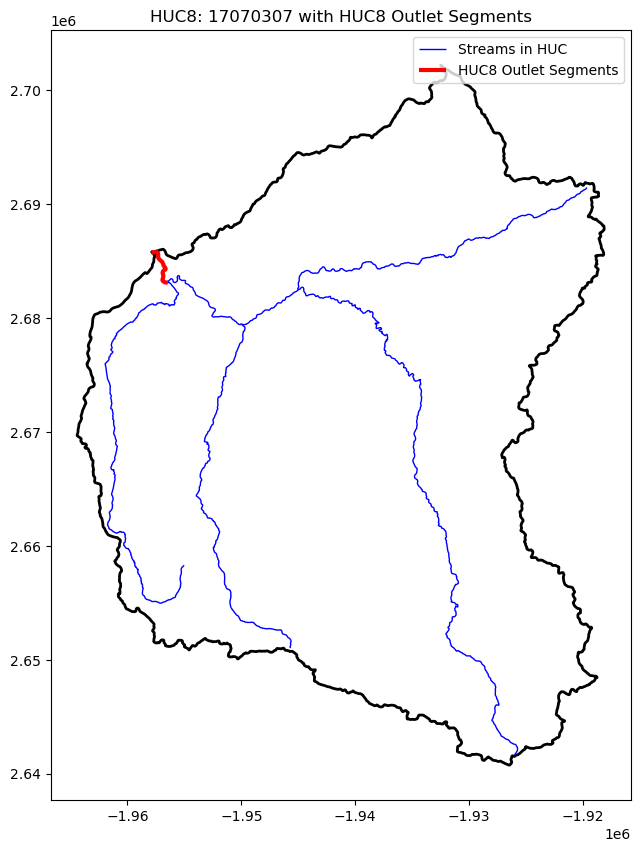

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


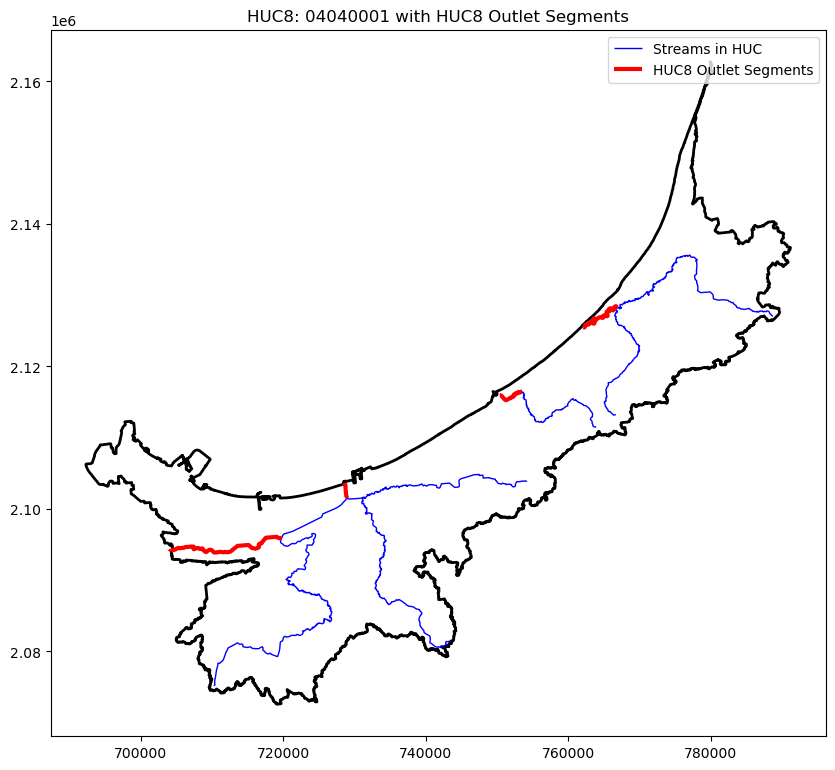

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


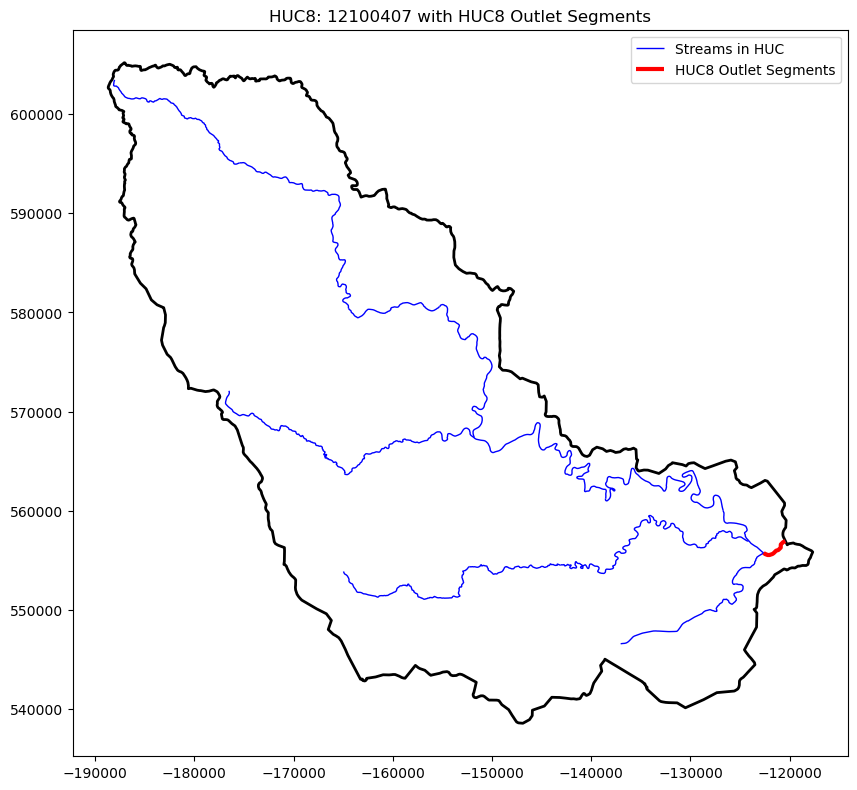

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


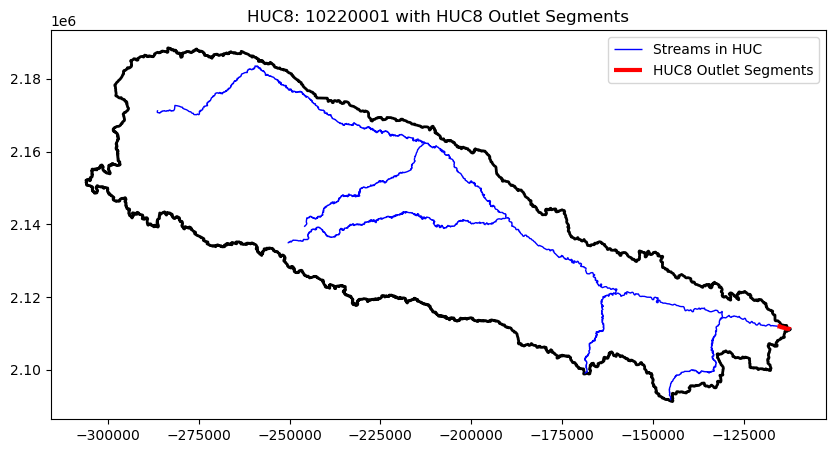

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


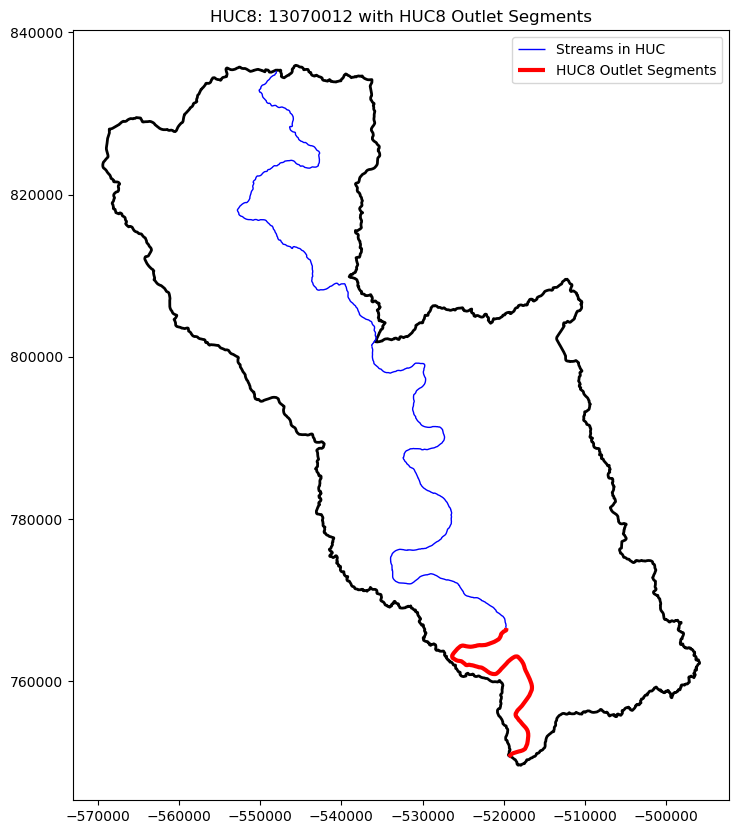

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


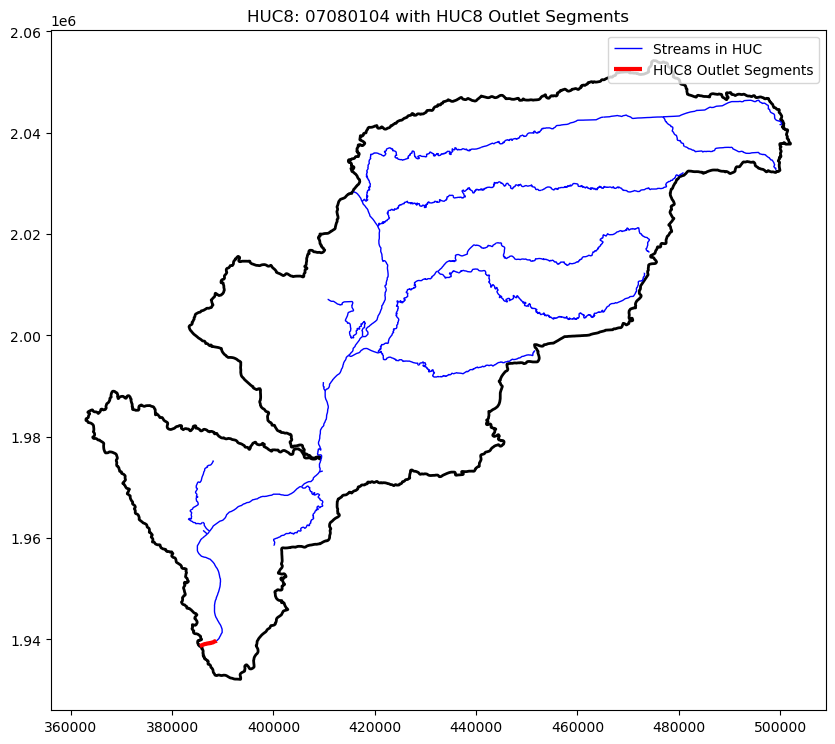

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


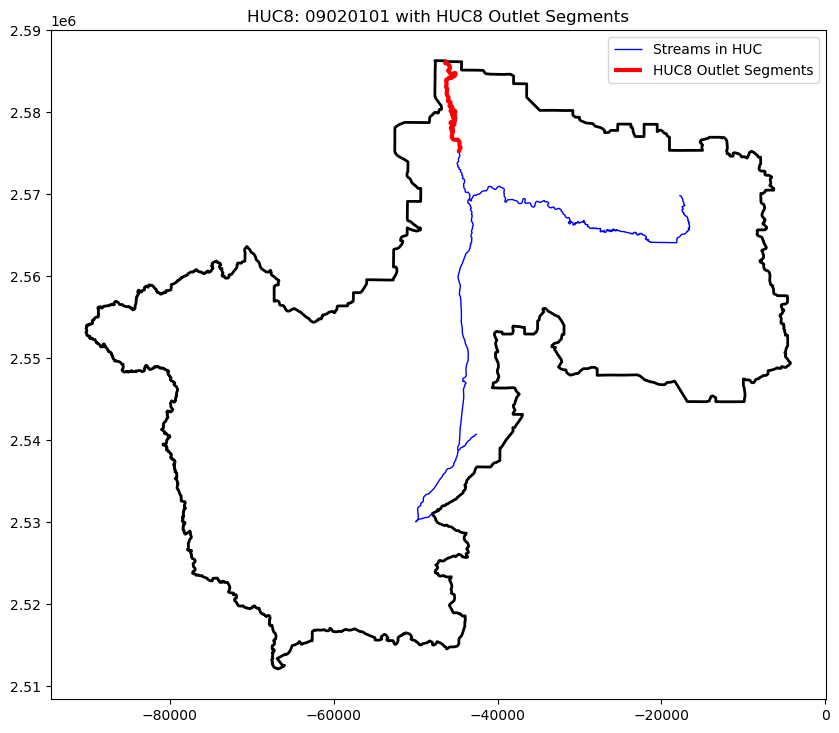

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


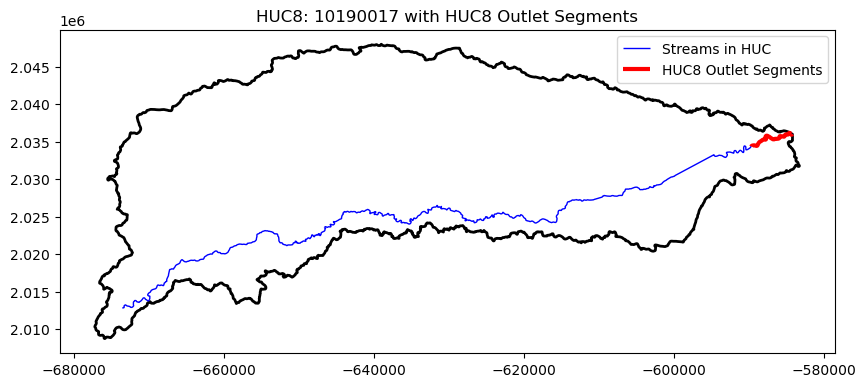

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


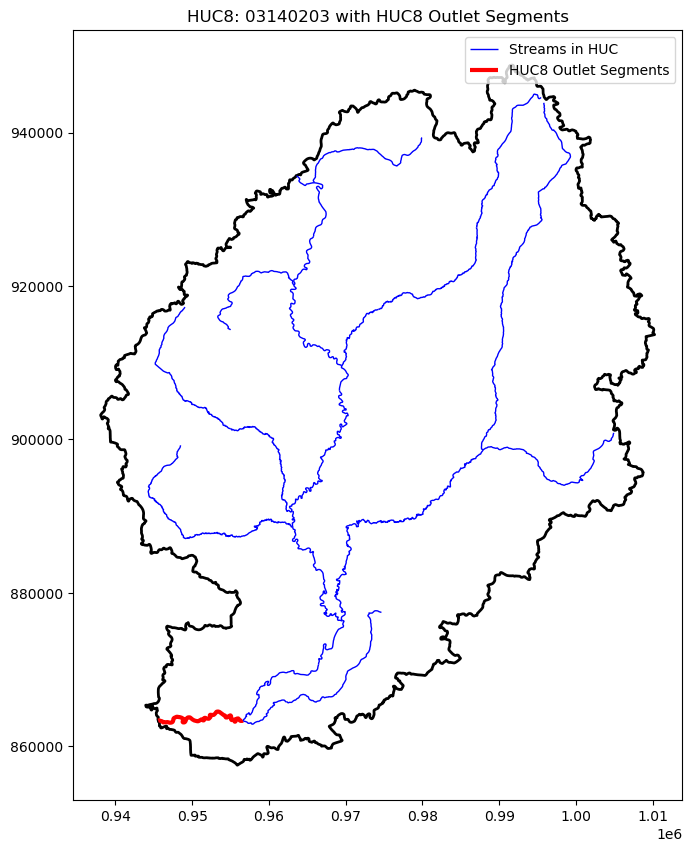

/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


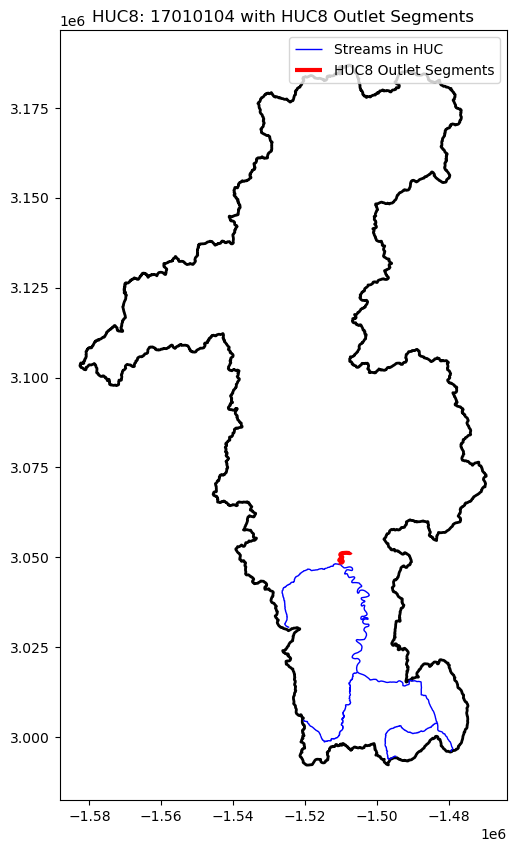

In [62]:
# pick 20 random HUC8s
random_huc8s = random.sample(list(gf_seg_gdf['huc8'].unique()), 20)

for random_huc8 in random_huc8s:
    plot_huc_outlets(seg_joined, [random_huc8], seg_joined[seg_joined['huc8'] == random_huc8][seg_joined['huc8_outlet'] == True], label='HUC8 Outlet Segments')

### Save

In [ ]:
# check for "bytes" columns - these will give an error when trying to save to shp

[col for col in seg_joined.columns
 if seg_joined[col].apply(lambda x: isinstance(x, (bytes, bytearray))).any()]

['GNIS_NAME']

In [66]:
seg_joined["GNIS_NAME"] = seg_joined["GNIS_NAME"].str.decode("utf-8")

In [67]:
seg_joined.rename(columns={'huc8_outlet': 'h8_outlet'}, inplace=True)
seg_joined.to_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg_h8_outlets.shp")